## Edward is a library for probabilistic modelling.
Today we will implement simple linear regression in Edward.  
It is reimplementation of this [tutorial](http://edwardlib.org/tutorials/supervised-regression)
    

### Boilerplate

In [31]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation
from tempfile import NamedTemporaryFile
from IPython.display import HTML
import seaborn as sns
import numpy as np
import six
import tensorflow as tf

plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
# sns.set_palette("colorblind")
sess = ed.get_session()


In [32]:
# this can be done only before using Edward
# ed.set_seed(42)

### Build data set.
We will create a toy data set for demonstration purpose

In [33]:

def build_toy_dataset(N, w, noise_std=0.1):
  D = len(w)
  x = np.random.randn(N, D)
  y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
  return x, y

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D)
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

In [34]:
from edward.models import Normal
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

In [35]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [36]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 63.919


In [37]:
y_post = ed.copy(y, {w: qw, b: qb})

In [38]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0413401
Mean absolute error on test data:
0.155014


In [39]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  print(w_samples)
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

[ 0.1833442   0.7366913   0.55735058  1.34403026  1.23117948  1.56901121
 -0.54003429  1.86146712 -0.1815329   0.19514467]


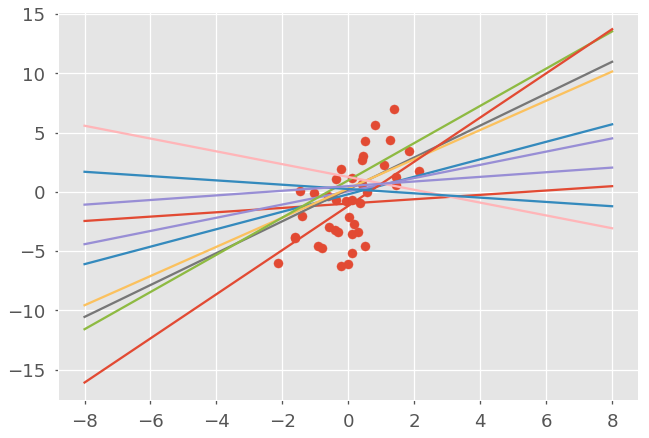

In [40]:
visualise(X_train, y_train, w, b)

In [48]:
from edward.models import Uniform,Normal
x = tf.range(-0.2, 1.2, 0.001)
plt.plot(*sess.run([x, Normal(low=0.0, high=1.0).prob(x)]));

TypeError: __init__() got an unexpected keyword argument 'high'